In [ ]:
!pip install gputil

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=0f061d7efe8a115dec2d99f6d634ab0dbd50397bf6659f8ce202eec5737456e1
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import psutil
import GPUtil
from tensorflow.keras.models import load_model

In [ ]:
def create_ocr_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')  # Assuming 26 classes for A-Z
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Generate random data for model training (for demo purposes)
X_train = np.random.rand(1000, 32, 32, 1)
y_train = tf.keras.utils.to_categorical(np.random.randint(26, size=(1000, 1)), num_classes=26)

# Create and train the model
model = create_ocr_model()
model.fit(X_train, y_train, epochs=3, batch_size=32)

# Save the trained model
model.save('ocr_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0399 - loss: 3.2785
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0347 - loss: 3.2528
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0440 - loss: 3.2497


In [ ]:
with tf.device('/GPU:0'):
    model_gpu = load_model('ocr_model.h5')

with tf.device('/CPU:0'):
    model_cpu = load_model('ocr_model.h5')

In [ ]:
def process_video_with_model(video_path, output_path, model, use_gpu=False):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    total_time = 0
    accuracies = []
    frame_times = []
    cpu_usages = []
    gpu_usages = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (32, 32))
        input_data = np.expand_dims(resized, axis=[0, -1]) / 255.0

        start_time = time.time()
        with tf.device('/GPU:0' if use_gpu else '/CPU:0'):
            predictions = model.predict(input_data)
        end_time = time.time()

        processing_time = end_time - start_time
        total_time += processing_time
        frame_times.append(processing_time)

        predicted_char = chr(np.argmax(predictions[0]) + 65)
        accuracy = np.max(predictions)
        accuracies.append(accuracy)

        # Capture CPU and GPU usage
        cpu_usage = psutil.cpu_percent(interval=None)
        gpu_usage = None
        if use_gpu:
            gpus = GPUtil.getGPUs()
            gpu_usage = gpus[0].load * 100 if gpus else 0

        cpu_usages.append(cpu_usage)
        gpu_usages.append(gpu_usage if use_gpu else 0)

        # Annotate video with performance metrics
        fontScale = 1.5
        thickness = 3
        cv2.putText(frame, f"Predicted: {predicted_char}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Processing Time: {processing_time:.2f}s", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Accuracy: {accuracy:.4f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"CPU Usage: {cpu_usage:.2f}%", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        if use_gpu:
            cv2.putText(frame, f"GPU Usage: {gpu_usage:.2f}%", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)

        out.write(frame)

        frame_count += 1

    average_fps = frame_count / total_time
    print(f"Average FPS ({'GPU' if use_gpu else 'CPU'}): {average_fps:.2f}")

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return average_fps, accuracies, frame_times, cpu_usages, gpu_usages

In [11]:
video_path = '/content/Video from Yadavalli Anjali.mp4'
output_path_gpu = 'output_video_gpu.avi'
output_path_cpu = 'output_video_cpu.avi'

In [12]:
fps_gpu, accuracies_gpu, frame_times_gpu, cpu_usages_gpu, gpu_usages = process_video_with_model(video_path, output_path_gpu, model_gpu, use_gpu=True)
fps_cpu, accuracies_cpu, frame_times_cpu, cpu_usages_cpu, _ = process_video_with_model(video_path, output_path_cpu, model_cpu, use_gpu=False)

print(f"Average FPS (GPU): {fps_gpu:.2f}")
print(f"Average FPS (CPU): {fps_cpu:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

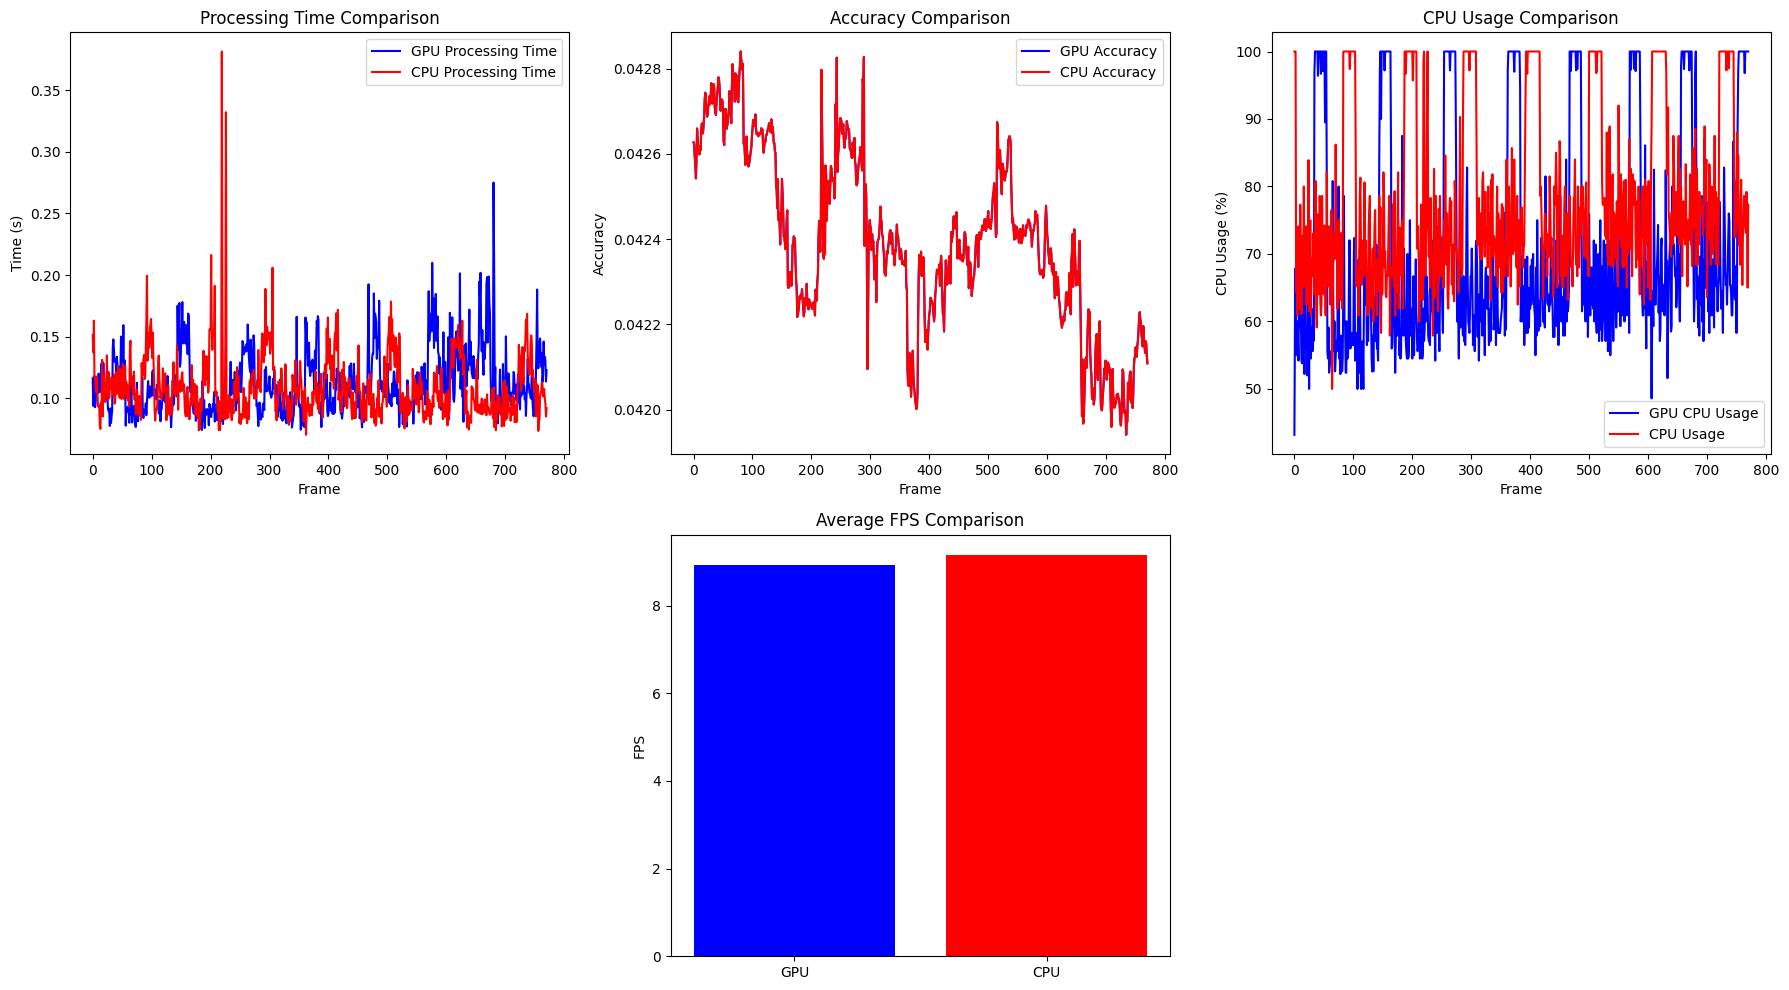

Performance Evaluation:
FPS (GPU): 8.92
FPS (CPU): 9.16
Average CPU Usage (GPU mode): 71.14%
Average CPU Usage (CPU mode): 78.52%


In [13]:
def plot_performance_comparison(frame_times_gpu, accuracies_gpu, frame_times_cpu, accuracies_cpu, cpu_usages_gpu, cpu_usages_cpu, gpu_usages):
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(frame_times_gpu, label='GPU Processing Time', color='blue')
    plt.plot(frame_times_cpu, label='CPU Processing Time', color='red')
    plt.title('Processing Time Comparison')
    plt.xlabel('Frame')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(accuracies_gpu, label='GPU Accuracy', color='blue')
    plt.plot(accuracies_cpu, label='CPU Accuracy', color='red')
    plt.title('Accuracy Comparison')
    plt.xlabel('Frame')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(cpu_usages_gpu, label='GPU CPU Usage', color='blue')
    plt.plot(cpu_usages_cpu, label='CPU Usage', color='red')
    plt.title('CPU Usage Comparison')
    plt.xlabel('Frame')
    plt.ylabel('CPU Usage (%)')
    plt.legend()
    plt.subplot(2, 3, 5)
    plt.bar(['GPU', 'CPU'], [fps_gpu, fps_cpu], color=['blue', 'red'])
    plt.title('Average FPS Comparison')
    plt.ylabel('FPS')

    plt.tight_layout()
    plt.show()

plot_performance_comparison(frame_times_gpu, accuracies_gpu, frame_times_cpu, accuracies_cpu, cpu_usages_gpu, cpu_usages_cpu, gpu_usages)
print("Performance Evaluation:")
print(f"FPS (GPU): {fps_gpu:.2f}")
print(f"FPS (CPU): {fps_cpu:.2f}")
print(f"Average CPU Usage (GPU mode): {np.mean(cpu_usages_gpu):.2f}%")
print(f"Average CPU Usage (CPU mode): {np.mean(cpu_usages_cpu):.2f}%")
